## Summary

Example notebook showing how to use ELASPIC2 to predict the effect of mutations on the affinity of the SARS-CoV-2 spike protein to the ACE2 receptor.

## Google colab

In [1]:
try:
    import google.colab
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False
    
GOOGLE_COLAB

True

In [2]:
if GOOGLE_COLAB:
    !pip install "torch==1.8.1";
    !pip install -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html --default-timeout=600 \
        "transformers==3.3.1" \
        "torch-scatter==2.0.6" \
        "torch-sparse==0.6.9" \
        "torch-cluster==1.5.9" \
        "torch-spline-conv==1.2.1" \
        "torch-geometric==1.6.1" \
        "https://gitlab.com/kimlab/kmbio/-/archive/v2.1.0/kmbio-v2.1.0.zip" \
        "https://gitlab.com/kimlab/kmtools/-/archive/v0.2.8/kmtools-v0.2.8.zip" \
        "https://gitlab.com/ostrokach/proteinsolver/-/archive/v0.1.25/proteinsolver-v0.1.25.zip" \
        "git+https://gitlab.com/elaspic/elaspic2.git"

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     - 13.0MB 22.6MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     \ 38.2MB 158kB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     / 188.5MB 2.2MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://gitlab.com/elaspic/elaspic2.git to /tmp/pip-req-build-tato32pl
  Running command git clone -q https://gitlab.com/elaspic/elaspic2.git /tmp/pip-req-build-tato32pl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 11.9MB 6.2MB/s 
     |████████████████████████████████| 24.3MB 1.4MB/s 
     |██████

## Imports

In [3]:
import io
import tempfile
from pathlib import Path

import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
from kmbio import PDB
from kmtools import structure_tools
from scipy import stats
from tqdm.notebook import tqdm

## Parameters

In [4]:
NOTEBOOK_DIR = Path("10_affinity_demo").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/content/10_affinity_demo')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## Helper functions

In [6]:
def download_csv(url):
    header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
    }
    df = pd.read_csv(io.StringIO(requests.get(url, headers=header).text))
    return df

In [7]:
def structure_to_blob(structure):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as out:
        PDB.save(structure, out.name)
        with open(out.name, "rt") as fin:
            data = fin.read()
    return data

In [8]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [9]:
def parse_mutation_data(structure, stability_df):
    amino_acids = "GVALICMFWPDESTYQNKRH"
    assert len(set(amino_acids)) == 20

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    ligand_sequence = structure_tools.get_chain_sequence(
        structure[0]["B"], if_unknown="replace", unknown_residue_marker=""
    )
    resnum_to_idx_mapping = {r.id[1]: i for i, r in enumerate(structure[0]["A"])}

    mutations = []
    effects = []
    num_mismatches = 0
    for tup in affinity_df.itertuples():
        idx = resnum_to_idx_mapping.get(tup.site_SARS2)
        if idx is None or chain_sequence[idx] != tup.wildtype:
            num_mismatches += 1
            # print(idx, tup)
            continue
        if tup.wildtype not in amino_acids or tup.mutant not in amino_acids:
            if tup.mutant != "*":
                print(f"Skipping strange mutation {tup.wildtype} → {tup.mutant}.")
            continue
        elif tup.wildtype == tup.mutant:
            # Exclude "mutations" where the wildtype and mutant residues are the same
            continue
        elif pd.isnull(tup.bind_avg):
            # For some reason, the effect is missing in some rows
            continue
        mutations.append(f"{tup.wildtype}{idx + 1}{tup.mutant}")
        effects.append(tup.bind_avg)
    print(f"Num mismatches: {num_mismatches}.")

    results = [
        {
            "dataset": NOTEBOOK_DIR.name,
            "name": f"spike-unbound|spike-closed",
            "protein_sequence": chain_sequence,
            "ligand_sequence": ligand_sequence,
            "mutation": mutations,
            "effect": effects,
            "effect_type": "Deep mutation scan",
            "protein_structure": structure_to_blob(structure),
        }
    ]
    return results

## Workspace

### Load protein structure

In [10]:
structure_ref = PDB.load("rcsb://6M0J.pdb")

In [11]:
PDB.view_structure(structure_ref)

NGLWidget()

In [12]:
structure = PDB.Structure("rbd-ace2")
model = PDB.Model(0)
structure.add(model)
chain2 = structure_ref[0]["A"].copy()
chain2.id = "B"
chain1 = structure_ref[0]["E"].copy()
chain1.id = "A"
model.add(chain1)
model.add(chain2)

In [13]:
PDB.view_structure(structure)

NGLWidget()

### Load a list of mutations

In [14]:
affinity_df = download_csv("https://ars.els-cdn.com/content/image/1-s2.0-S0092867420310035-mmc2.csv")

In [15]:
affinity_df.tail()

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
4216,201,531,T,T,T531T,T201T,0.00,0.00,0.00,0.00,0.00,0.00
4217,201,531,T,V,T531V,T201V,0.03,-0.02,0.01,-0.07,-0.05,-0.06
4218,201,531,T,W,T531W,T201W,0.02,-0.06,-0.02,-0.13,-0.04,-0.08
4219,201,531,T,Y,T531Y,T201Y,0.00,-0.03,-0.01,-0.03,-0.08,-0.05
4220,201,531,T,*,T531*,T201*,NaN,NaN,NaN,-4.59,-4.51,-4.55


### Parse mutation data

In [16]:
protein_mutation_info = parse_mutation_data(structure, affinity_df)[0]

list(protein_mutation_info.keys())

Num mismatches: 147.


['dataset',
 'name',
 'protein_sequence',
 'ligand_sequence',
 'mutation',
 'effect',
 'effect_type',
 'protein_structure']

### Featurize model

In [17]:
model = el2.ELASPIC2(device=device)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [18]:
structure_file_obj = tempfile.NamedTemporaryFile(suffix=".pdb")
PDB.save(structure, structure_file_obj.name)

In [19]:
protein_stability_features = model.build(
    structure_file=structure_file_obj.name,
    protein_sequence=protein_mutation_info["protein_sequence"],
    ligand_sequence=None,
    remove_hetatms=True,
)

protein_stability_features

ELASPIC2Data(is_interface=False, protbert_data=ProtBertData(sequence='TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'), proteinsolver_data=Data(edge_attr=[8816, 2], edge_index=[2, 8816], x=[194]))

In [20]:
protein_affinity_features = model.build(
    structure_file=structure_file_obj.name,
    protein_sequence=protein_mutation_info["protein_sequence"],
    ligand_sequence=protein_mutation_info["ligand_sequence"],
    remove_hetatms=True,
)

protein_affinity_features

ELASPIC2Data(is_interface=True, protbert_data=ProtBertData(sequence='TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGSTIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQQNGSSVLSEDKSKRLNTILNTMSTIYSTGKVCNPDNPQECLLLEPGLNEIMANSLDYNERLWAWESWRSEVGKQLRPLYEEYVVLKNEMARANHYEDYGDYWRGDYEVNGVDGYDYSRGQLIEDVEHTFEEIKPLYEHLHAYVRAKLMNAYPSYISPIGCLPAHLLGDMWGRFWTNLYSLTVPFGQKPNIDVTDAMVDQAWDAQRIFKEAEKFFVSVGLPNMTQGFWENSMLTDPGNVQKAVCHPTAWDLGKGDFRILMCTKVTMDDFLTAHHEMGHIQYDMAYAAQPFLLRNGANEGFHEAVGEIMSLSAATPKHLKSIGLLSPDFQEDNETEINFLLKQALTIVGTLPFTYMLEKWRWMVFKGEIPKDQWMKKWWEMKREIVGVVEPVPHDETYCDPASLFHVSNDYSFIRYYTRTLYQFQFQEALCQAAKHEGPLHKCDISNSTEAGQKLFNMLRLGKSEPWTLALENVVGAKNMNVRPLLNYFEPLFTWLKDQNKNSFVGWSTDWSPYAD'), proteinsolver_data=Data(edge_attr=[43268, 2], edge_index=[2, 43268], x=[791]))

### Featurize mutations

In [21]:
mutation_affinity_features = list(
    tqdm(
        (
            model.analyze_mutation(mut, protein_affinity_features)
            for mut in protein_mutation_info["mutation"]
        ),
        total=len(protein_mutation_info["mutation"]),
    )
)

In [22]:
mutation_stability_features = list(
    tqdm(
        (
            model.analyze_mutation(mut, protein_stability_features)
            for mut in protein_mutation_info["mutation"]
        ),
        total=len(protein_mutation_info["mutation"]),
    )
)

### Predict mutation effects on stability

In [23]:
# Reverse the effect value, because higher values mean more stable (opposite of ΔΔG)
affinity_pred = model.predict_mutation_effect(mutation_stability_features, mutation_affinity_features)
affinity_actual = -np.array(protein_mutation_info["effect"])

### Show results

In [24]:
corr = stats.spearmanr(affinity_pred, affinity_actual)

corr

SpearmanrResult(correlation=0.6244605768771687, pvalue=0.0)

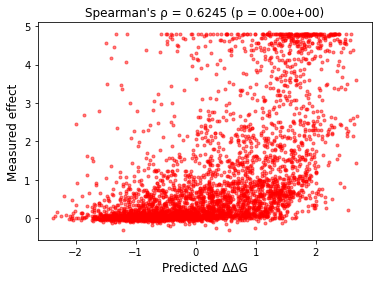

In [25]:
fg, ax = plt.subplots()

ax.plot(affinity_pred, affinity_actual, "r.", alpha=0.5)

ax.set_xlabel("Predicted ΔΔG", fontsize="large")
ax.set_ylabel("Measured effect", fontsize="large")
ax.set_title(f"Spearman's ρ = {corr[0]:.4f} (p = {corr[1]:.2e})")
None